# Passenger Load Prediction Project

### 2 Pax Load Factor Prediction

This notebook builds the reproducible machine learning pipeline for predicting the passenger load factor per flight route. The cleaned dataset generated in the previous exploratory and preprocessing phase (see 1_eda_and_cleaning.ipynb) is used. The goal is to develop a robust model that can support airlines in optimizing route planning and capacity management.

The goal of the model is to predict the **Passenger Load Factor** per flight route. This value represents the ratio between passengers carried and available seats, indicating how efficiently the aircraft capacity is utilized.

Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
import shap

/Users/verena/DBU/Applied Data Science II/Prüfungsleistung/Passenger Forecast/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the cleaned data

Dataset Structure and Input Requirements:

This notebook assumes a preprocessed dataset as produced by `1_eda_and_cleaning.ipynb`.

The dataset must contain the following columns:
- `carrier_group` (categorical): Airline group
- `aircraft_type` (categorical): Aircraft model or category
- `departures_performed` (numeric): Number of flights performed
- `payload` (numeric): Total payload weight in kg
- `freight` (numeric): Freight load in kg
- `mail` (numeric): Mail load in kg
- `distance` (numeric): Flight distance in km
- `air_time` (numeric): Average flight duration in minutes
- `pax_load_factor` (numeric): Target variable, percentage of passenger seat occupancy


In [4]:
pax_load_data = pd.read_csv('../data/passenger_load_data.csv')

Define features and target y

In [5]:
# Define target
target = "pax_load_factor"

# Drop target & non-feature columns
X = pax_load_data.drop(columns=[target])
y = pax_load_data[target]

# Identify feature types
num_features = X.select_dtypes(include=["int64", "float64", "Int64", "Float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

Numerical features: ['departures_performed', 'payload', 'freight', 'mail', 'distance', 'air_time', 'carrier_group', 'aircraft_type', 'aircraft_config']
Categorical features: ['route']


Preprocessing: Imputing, scaling and encoding

Numerical features are imputed (median) and scaled. Categorical features are imputed (most frequent) and one-hot encoded. Even though the current dataset has no missing values, imputers are included to ensure robustness on operational data.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",
         Pipeline([("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]),
         num_features),
        ("cat",
         Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]),
         cat_features),
    ],
    remainder="drop",
)

##### Prediction of new flights on known routes

Split the data into train- and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Check shape of train data

In [8]:
X_train.shape

(288151, 10)

Define models

To evaluate different approaches for predicting the passenger load factor, several regression models are compared.
A simple baseline model (predicting the mean value) is used as a reference to assess the predictive quality of more complex models.

In [9]:
models = {
    "Baseline (Mean)": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1,random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(max_depth=3, n_estimators=200, random_state=42)
}

Train, predict and evaluate results

In [10]:
evaluation_results = []

CV = 3

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

# Cross-validation - training on folds
    cv = cross_validate(pipeline, X_train, y_train, cv=CV, scoring={"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}, n_jobs=-1, return_train_score=False)

# Train the model
    pipeline.fit(X_train, y_train)   

# Predict target
    y_pred = pipeline.predict(X_test)

    evaluation_results.append({
        "Model": name,
        "CV_R2_Mean": np.mean(cv["test_r2"]),
        "CV_MAE_Mean": -np.mean(cv["test_mae"]),
        "CV_RMSE_Mean": -np.mean(cv["test_rmse"]),
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

# Convert results to DataFrame
results_df = pd.DataFrame(evaluation_results).sort_values("Test_R2", ascending=False)
results_df



,Model,CV_R2_Mean,CV_MAE_Mean,CV_RMSE_Mean,Test_R2,Test_MAE,Test_RMSE
2,Random Forest,0.487954,0.110877,0.149834,0.493021,0.110509,0.149453
3,Gradient Boosting,0.439051,0.117414,0.156826,0.442419,0.117284,0.156734
1,Linear Regression,0.427215,0.113101,0.158472,0.441973,0.111824,0.156797
0,Baseline (Mean),-0.000003,0.160391,0.209390,-0.000018,0.160752,0.209900


In [11]:
# Best Model
best_row = results_df.loc[results_df["Test_R2"].idxmax()]

best_model_name = best_row["Model"]
best_model_r2 = best_row["Test_R2"]
best_model_mae = best_row["Test_MAE"]
best_model_rmse = best_row["Test_RMSE"]

print("Best Performing Model (by R²):")
print(f"Model: {best_model_name}")
print(f"R² on Test Set: {best_model_r2:.3f}")
print(f"MAE on Test Set: {best_model_mae:.3f}")
print(f"RMSE on Test Set: {best_model_rmse:.3f}")

Best Performing Model (by R²):
Model: Random Forest
R² on Test Set: 0.493
MAE on Test Set: 0.111
RMSE on Test Set: 0.149


Error Plots for Best Model

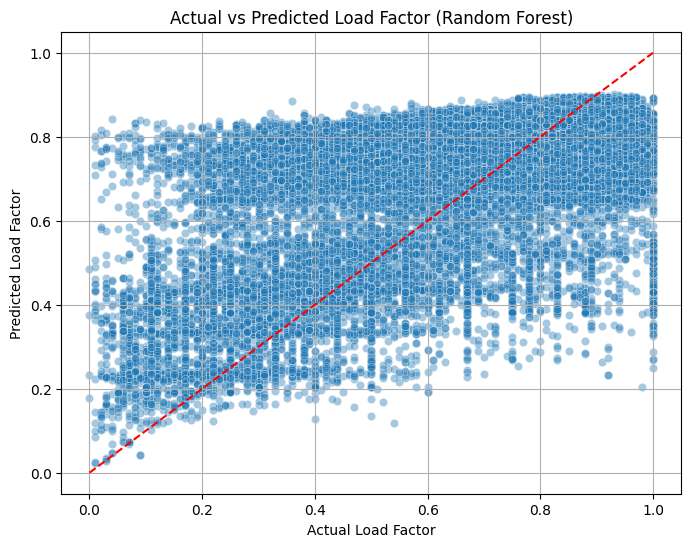

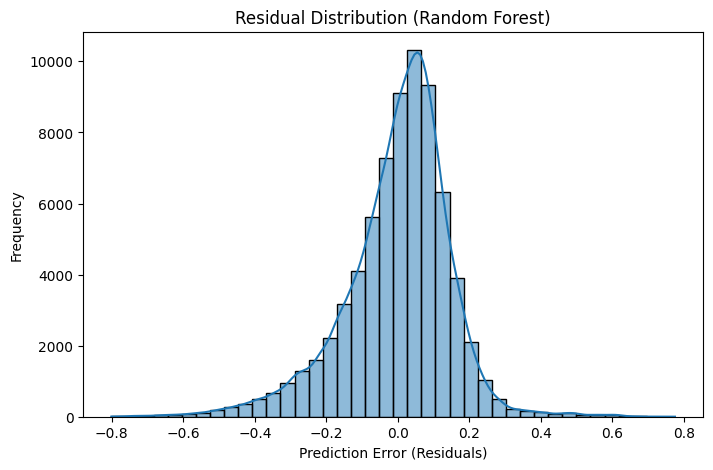

In [12]:
# Retrain best model on full training data and predict on test set
best_model = models[best_model_name]
best_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_model)
])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title(f"Actual vs Predicted Load Factor ({best_model_name})")
plt.xlabel("Actual Load Factor")
plt.ylabel("Predicted Load Factor")
plt.grid(True)
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Residual Distribution ({best_model_name})")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()


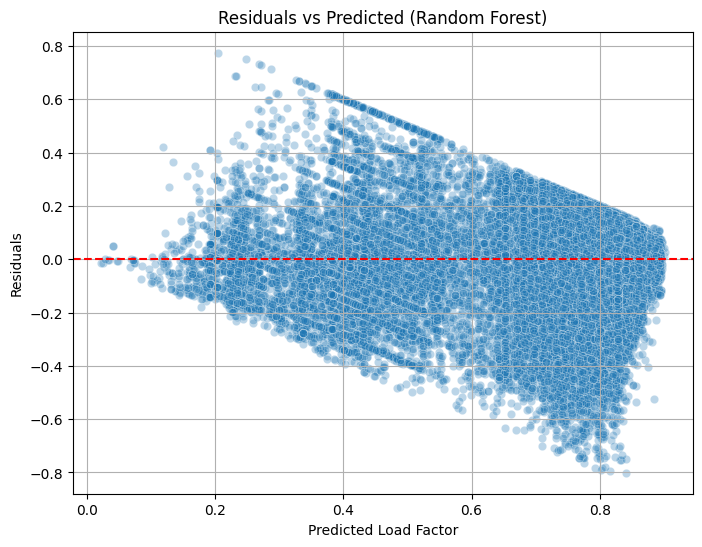

In [13]:
# Plot Predicted vs Residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals vs Predicted ({best_model_name})")
plt.xlabel("Predicted Load Factor")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


In [14]:
# Define the parameter space for Random Forest
params = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt", "log2"]
}

# Define the pipeline again (using the best model)
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

# Initialize randomized search
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    n_iter=30,                 # number of parameter combinations tested
    cv=3,                      # 3-fold cross-validation
    scoring="r2",              # metric for model performance
    n_jobs=-1,                 # use all cores
    verbose=2,
    random_state=42
)

# Fit randomized search
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:")
print(random_search.best_params_)
print("\nBest CV R² Score:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  13.1s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  13.1s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  13.5s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  13.5s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=171; total time=  18.9s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=171; total time=  19.2s
[CV] END 

Evaluate the best tuned model on the test set

In [15]:
# Select best estimator
best_pipeline = random_search.best_estimator_   
y_pred_tuned = best_pipeline.predict(X_test)

# Evaluation metrics
r2  = r2_score(y_test, y_pred_tuned)
mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print("Test R²:",  round(r2, 3))
print("Test MAE:", round(mae, 3))
print("Test RMSE:", round(rmse, 3))

Test R²: 0.346
Test MAE: 0.131
Test RMSE: 0.17


Hyperparameter Tuning Results Analysis

Performance Comparison:
                 Model      R2     MAE    RMSE
0        Random Forest  0.4930  0.1105  0.1495
1  Tuned Random Forest  0.3458  0.1306  0.1698

Performance Changes after Tuning:
R² change: -0.1472 (degradation)
MAE change: 0.0200 (degradation)
RMSE change: 0.0203 (degradation)

Best parameters found:
model__max_depth: 50
model__max_features: sqrt
model__min_samples_leaf: 4
model__min_samples_split: 2
model__n_estimators: 289


/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/3330957228.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/3330957228.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/3330957228.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


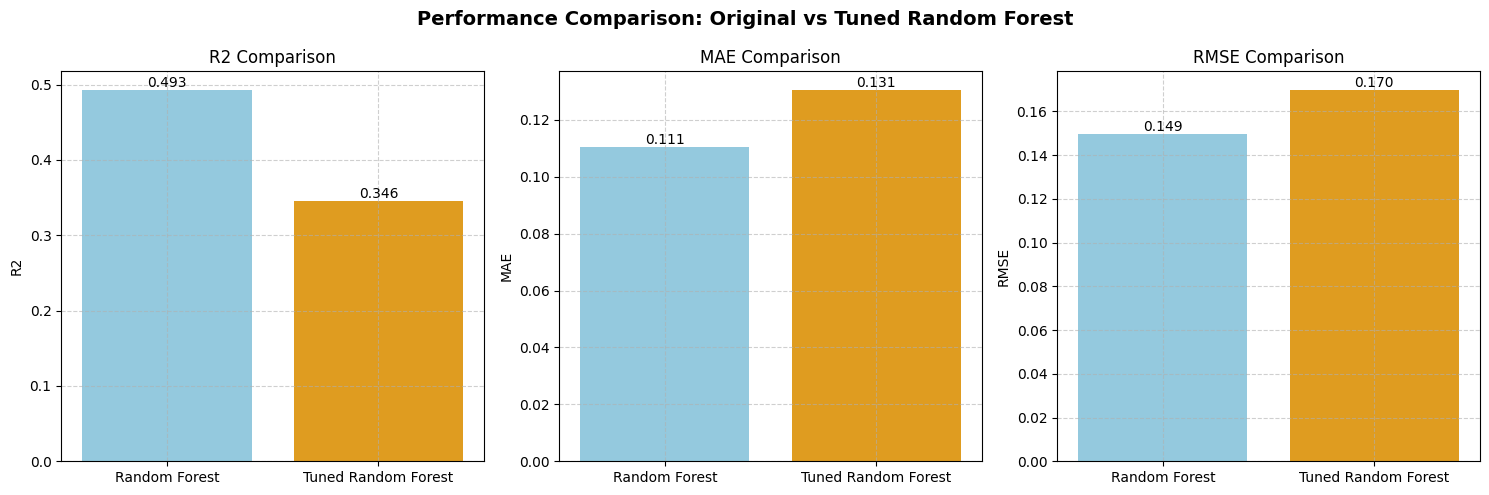

In [16]:
# Compare the original Random Forest from the model comparison vs the tuned version
# Initial metrics of the original Random Forest
initial_results = {
    "Model": "Random Forest",
    "R2": results_df.loc[results_df["Model"] == "Random Forest", "Test_R2"].values[0],
    "MAE": results_df.loc[results_df["Model"] == "Random Forest", "Test_MAE"].values[0],
    "RMSE": results_df.loc[results_df["Model"] == "Random Forest", "Test_RMSE"].values[0],
}

# Tuned Random Forest (from hyperparameter search)
best_rf = random_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

tuned_results = {
    "Model": "Tuned Random Forest",
    "R2": r2_score(y_test, y_pred_tuned),
    "MAE": mean_absolute_error(y_test, y_pred_tuned),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_tuned))
}

# Compare results
compare_df = pd.DataFrame([initial_results, tuned_results])
print("Performance Comparison:")
print(compare_df.round(4))

# Calculate improvement/degradation
r2_change = tuned_results["R2"] - initial_results["R2"]
mae_change = tuned_results["MAE"] - initial_results["MAE"]
rmse_change = tuned_results["RMSE"] - initial_results["RMSE"]

print(f"\nPerformance Changes after Tuning:")
print(f"R² change: {r2_change:.4f} ({'improvement' if r2_change > 0 else 'degradation'})")
print(f"MAE change: {mae_change:.4f} ({'improvement' if mae_change < 0 else 'degradation'})")
print(f"RMSE change: {rmse_change:.4f} ({'improvement' if rmse_change < 0 else 'degradation'})")

# Check the best parameters found
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

# Visualize comparison
metrics = ["R2", "MAE", "RMSE"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    sns.barplot(
        data=compare_df,
        x="Model",
        y=metric,
        ax=axes[i],
        palette=["skyblue", "orange"]
    )
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    
    # Add value labels on bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f')

plt.suptitle("Performance Comparison: Original vs Tuned Random Forest", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

GridSearch: More conservative approach with reasonable parameter bounds

In [17]:
# Conservative parameter search with reasonable bounds
conservative_params = {
    "model__n_estimators": [100, 120],          # 2 values around the original
    "model__max_depth": [10, 12, 15],           # 3 values around the original
    "model__min_samples_split": [2, 5],         
    "model__max_features": ["sqrt", "log2"]     
}


# GridSearchCV with reduced search space
conservative_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

conservative_search = GridSearchCV(
    conservative_pipeline,
    param_grid=conservative_params,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

conservative_search.fit(X_train, y_train)

print("\nBest Conservative Parameters:")
print(conservative_search.best_params_)
print(f"Best CV R² Score: {conservative_search.best_score_:.4f}")

# Test the conservative model
y_pred_conservative = conservative_search.best_estimator_.predict(X_test)
conservative_r2 = r2_score(y_test, y_pred_conservative)
conservative_mae = mean_absolute_error(y_test, y_pred_conservative)
conservative_rmse = np.sqrt(mean_squared_error(y_test, y_pred_conservative))

print(f"\nConservative Model Test Results:")
print(f"R²: {conservative_r2:.4f}")
print(f"MAE: {conservative_mae:.4f}")
print(f"RMSE: {conservative_rmse:.4f}")

# Compare all three approaches
comparison_data = [
    {"Model": "Original RF", "R2": initial_results["R2"], "MAE": initial_results["MAE"], "RMSE": initial_results["RMSE"]},
    {"Model": "Aggressive Tuning", "R2": tuned_results["R2"], "MAE": tuned_results["MAE"], "RMSE": tuned_results["RMSE"]},
    {"Model": "Conservative Tuning", "R2": conservative_r2, "MAE": conservative_mae, "RMSE": conservative_rmse}
]

final_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*50)
print("Final Comparison:")
print("="*50)
print(final_comparison.round(4))

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Conservative Parameters:
{'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 120}
Best CV R² Score: 0.1811

Best Conservative Parameters:
{'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 120}
Best CV R² Score: 0.1811

Conservative Model Test Results:
R²: 0.1793
MAE: 0.1471
RMSE: 0.1901

Final Comparison:
                 Model      R2     MAE    RMSE
0          Original RF  0.4930  0.1105  0.1495
1    Aggressive Tuning  0.3458  0.1306  0.1698
2  Conservative Tuning  0.1793  0.1471  0.1901

Conservative Model Test Results:
R²: 0.1793
MAE: 0.1471
RMSE: 0.1901

Final Comparison:
                 Model      R2     MAE    RMSE
0          Original RF  0.4930  0.1105  0.1495
1    Aggressive Tuning  0.3458  0.1306  0.1698
2  Conservative Tuning  0.1793  0.1471  0.1901


##### Prediction of new flights on new/unknown routes

In [18]:
# GroupShuffleSplit to ensure no data leakage on routes
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split = gss.split(X, y, groups=X["route"])

train_idx, test_idx = next(split)
X_train_route, X_test_route = X.iloc[train_idx], X.iloc[test_idx]
y_train_route, y_test_route = y.iloc[train_idx], y.iloc[test_idx]


Check distribution of routes in train and test set

# Train routes: 18088
# Test routes : 4523
# Overlap     : 0
No route appears in both Train and Test.


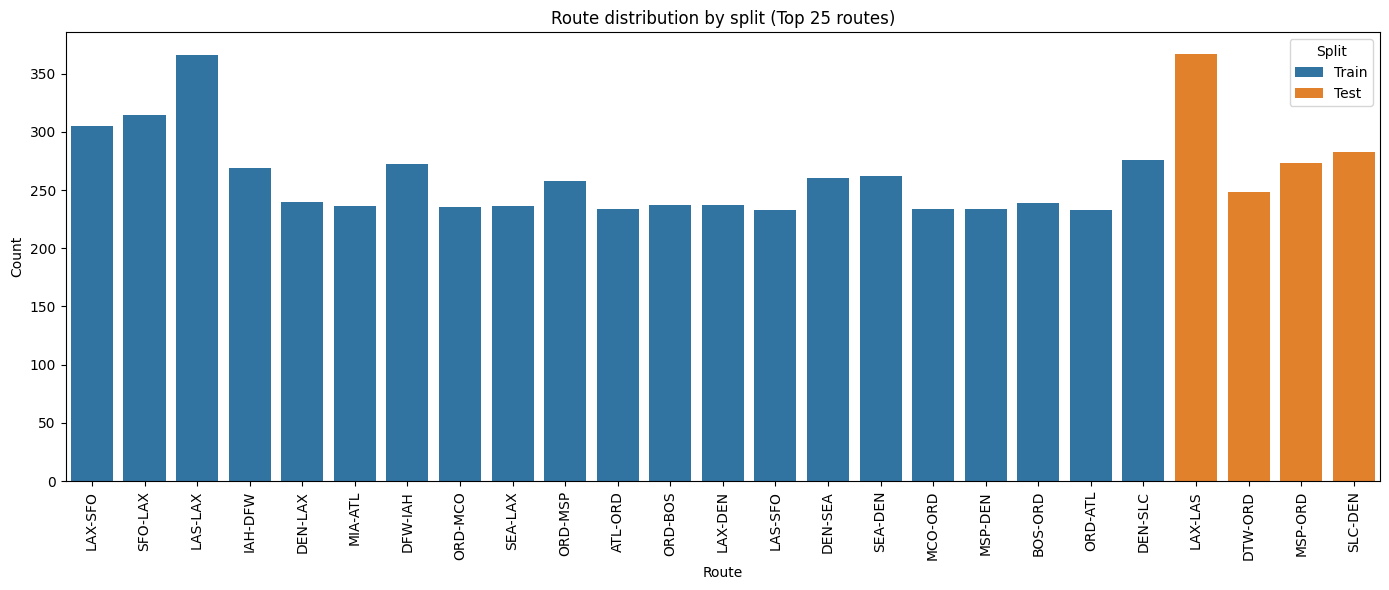

In [19]:
# Check overlap
train_routes = set(X_train_route["route"])
test_routes  = set(X_test_route["route"])

overlap = train_routes & test_routes
print(f"# Train routes: {len(train_routes)}")
print(f"# Test routes : {len(test_routes)}")
print(f"# Overlap     : {len(overlap)}")
if overlap:
    print("Example overlaps:", list(sorted(overlap))[:10])
else:
    print("No route appears in both Train and Test.")

# Visualize
train_vis = X_train_route[["route"]].copy()
train_vis["split"] = "Train"
test_vis = X_test_route[["route"]].copy()
test_vis["split"] = "Test"

vis_df = pd.concat([train_vis, test_vis], axis=0, ignore_index=True)

# Top N routes
N = 25
top_routes = (vis_df["route"].value_counts().head(N).index)
plot_df = vis_df[vis_df["route"].isin(top_routes)]

plt.figure(figsize=(14, 6))
ax = sns.countplot(data=plot_df, x="route", hue="split")
ax.set_title(f"Route distribution by split (Top {N} routes)")
ax.set_xlabel("Route")
ax.set_ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

...

In [ ]:
evaluation_results = []

group_cv = GroupKFold(n_splits=3)
cv_groups = X_train_route["route"]  

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

# Cross-validation - training on folds
    cv = cross_validate(pipeline, X_train_route, y_train_route, cv=group_cv.split(X_train_route, y_train_route, groups=cv_groups), scoring={"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}, n_jobs=-1, return_train_score=False)

# Train the model
    pipeline.fit(X_train_route, y_train_route)

# Predict target
    y_pred = pipeline.predict(X_test_route)

    evaluation_results.append({
        "Model": name,
        "CV_R2_Mean": np.mean(cv["test_r2"]),
        "CV_MAE_Mean": -np.mean(cv["test_mae"]),
        "CV_RMSE_Mean": -np.mean(cv["test_rmse"]),
        "Test_R2": r2_score(y_test_route, y_pred),  
        "Test_MAE": mean_absolute_error(y_test_route, y_pred),  
        "Test_RMSE": np.sqrt(mean_squared_error(y_test_route, y_pred))  
    })

# Convert results to DataFrame
results_df = pd.DataFrame(evaluation_results).sort_values("Test_R2", ascending=False)
results_df

,Model,CV_R2_Mean,CV_MAE_Mean,CV_RMSE_Mean,Test_R2,Test_MAE,Test_RMSE
2,Random Forest,0.470169,0.112955,0.152676,0.475429,0.111071,0.150641
3,Gradient Boosting,0.421773,0.118972,0.159508,0.426069,0.117302,0.157569
0,Baseline (Mean),-0.000206,0.160909,0.209844,-0.000086,0.159467,0.207998
1,Linear Regression,-0.010027,0.180436,0.210831,-0.015193,0.179393,0.209563


In [21]:
# Best Model
best_row = results_df.loc[results_df["Test_R2"].idxmax()]

best_model_name = best_row["Model"]
best_model_r2 = best_row["Test_R2"]
best_model_mae = best_row["Test_MAE"]
best_model_rmse = best_row["Test_RMSE"]

print("Best Performing Model (by R²):")
print(f"Model: {best_model_name}")
print(f"R² on Test Set: {best_model_r2:.3f}")
print(f"MAE on Test Set: {best_model_mae:.3f}")
print(f"RMSE on Test Set: {best_model_rmse:.3f}")

Best Performing Model (by R²):
Model: Random Forest
R² on Test Set: 0.475
MAE on Test Set: 0.111
RMSE on Test Set: 0.151


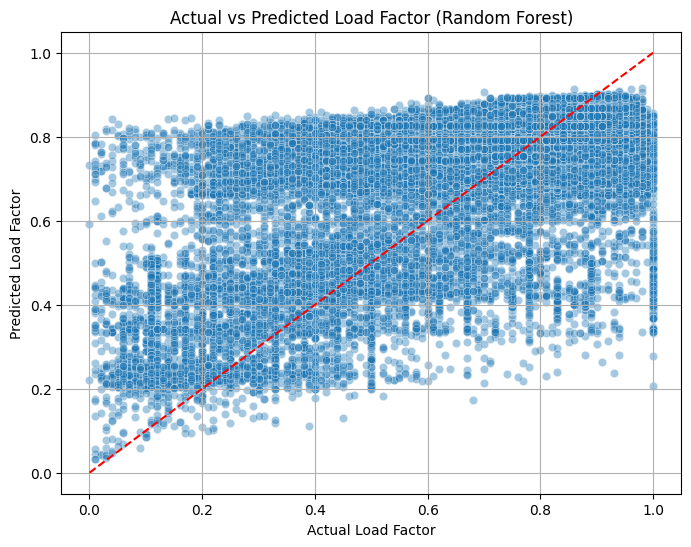

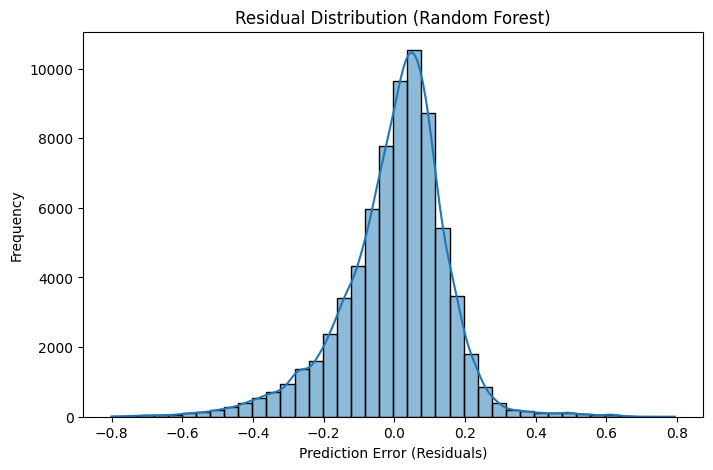

In [22]:
# Retrain best model on full training data and predict on test set
best_model = models[best_model_name]
best_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_model)
])
best_pipeline.fit(X_train_route, y_train_route)
y_pred = best_pipeline.predict(X_test_route)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_route, y=y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title(f"Actual vs Predicted Load Factor ({best_model_name})")
plt.xlabel("Actual Load Factor")
plt.ylabel("Predicted Load Factor")
plt.grid(True)
plt.show()

# Residuals Plot - Fixed: use y_test_route instead of y_test
residuals = y_test_route - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Residual Distribution ({best_model_name})")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()

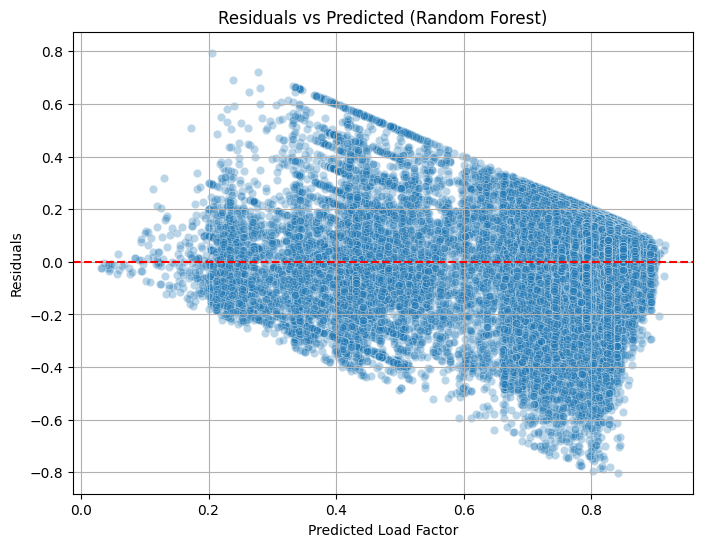

In [23]:
# Plot Predicted vs Residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals vs Predicted ({best_model_name})")
plt.xlabel("Predicted Load Factor")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [24]:
# Define the parameter space for Random Forest
params = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt", "log2"]
}

# Define the pipeline again (using the best model)
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

cv = GroupKFold(n_splits=3)
cv_groups = X_train_route["route"]

# Initialize randomized search
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    n_iter=30,                 # number of parameter combinations tested
    cv=3,                      # 3-fold cross-validation
    scoring="r2",              # metric for model performance
    n_jobs=-1,                 # use all cores
    verbose=2,
    random_state=42
)

# Fit randomized search
random_search.fit(X_train_route, y_train_route, groups=cv_groups)

# Best parameters and score
print("Best Parameters:")
print(random_search.best_params_)
print("\nBest CV R² Score:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/verena/DBU/Applied Data Science II/Prüfungsleistung/Passenger Forecast/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  14.8s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  15.1s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=199; total time=  15.1s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=171; total time=  22.3s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=171; total time=  22.3s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=171; total time=  22.6s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_sam

In [25]:
# Select best estimator
best_pipeline = random_search.best_estimator_   
y_pred_tuned = best_pipeline.predict(X_test_route)

# Evaluation metrics
r2  = r2_score(y_test_route, y_pred_tuned)
mae = mean_absolute_error(y_test_route, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test_route, y_pred_tuned))

print("Test R²:",  round(r2, 3))
print("Test MAE:", round(mae, 3))
print("Test RMSE:", round(rmse, 3))

Test R²: 0.327
Test MAE: 0.131
Test RMSE: 0.171


Performance Comparison (Route based Split):
                 Model      R2     MAE    RMSE
0        Random Forest  0.4754  0.1111  0.1506
1  Tuned Random Forest  0.3271  0.1307  0.1706

Performance Changes after Tuning:
R² change: -0.1483 (degradation)
MAE change: 0.0196 (degradation)
RMSE change: 0.0200 (degradation)

Best parameters found:
model__max_depth: 50
model__max_features: sqrt
model__min_samples_leaf: 4
model__min_samples_split: 2
model__n_estimators: 148


/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/146843433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/146843433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/146843433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


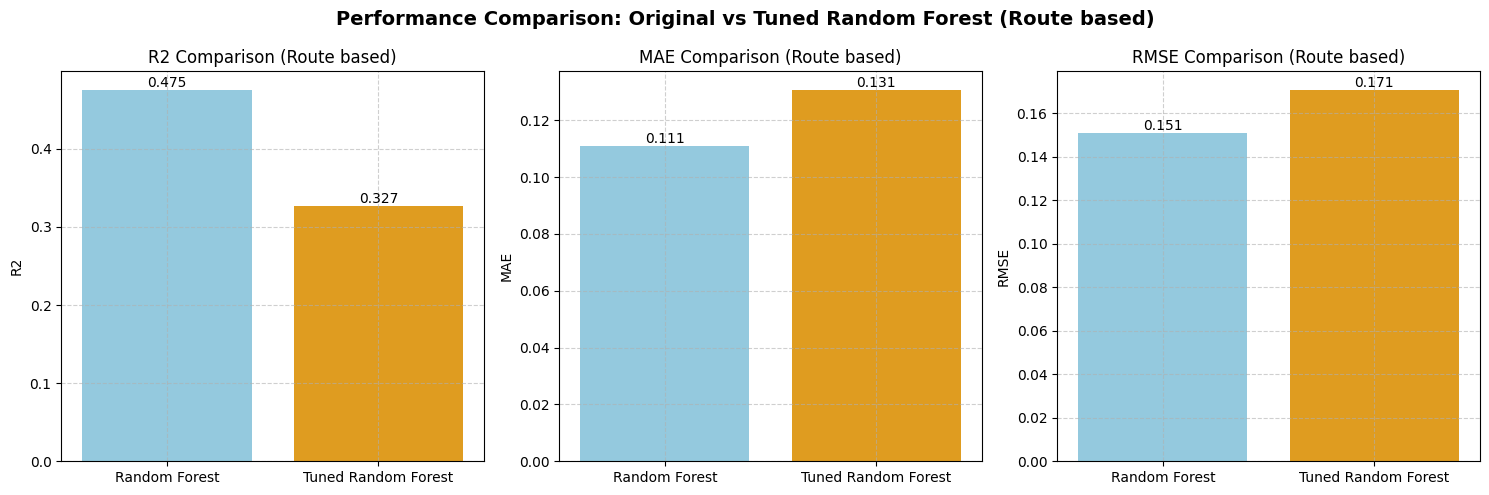

In [26]:
# Compare the original Random Forest from the model comparison vs the tuned version
# Initial Random Forest
initial_rf = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42))
])
initial_rf.fit(X_train_route, y_train_route)
y_pred_initial_route = initial_rf.predict(X_test_route)

initial_results_route = {
    "Model": "Random Forest",
    "R2": r2_score(y_test_route, y_pred_initial_route),
    "MAE": mean_absolute_error(y_test_route, y_pred_initial_route),
    "RMSE": np.sqrt(mean_squared_error(y_test_route, y_pred_initial_route)),
}

# Tuned Random Forest (from hyperparameter search)
best_rf = random_search.best_estimator_
y_pred_tuned_route = best_rf.predict(X_test_route)

tuned_results_route = {
    "Model": "Tuned Random Forest",
    "R2": r2_score(y_test_route, y_pred_tuned_route),
    "MAE": mean_absolute_error(y_test_route, y_pred_tuned_route),
    "RMSE": np.sqrt(mean_squared_error(y_test_route, y_pred_tuned_route))
}

# Compare results
compare_df_route = pd.DataFrame([initial_results_route, tuned_results_route])
print("Performance Comparison (Route based Split):")
print(compare_df_route.round(4))

# Calculate improvement/degradation
r2_change_route = tuned_results_route["R2"] - initial_results_route["R2"]
mae_change_route = tuned_results_route["MAE"] - initial_results_route["MAE"]
rmse_change_route = tuned_results_route["RMSE"] - initial_results_route["RMSE"]

print(f"\nPerformance Changes after Tuning:")
print(f"R² change: {r2_change_route:.4f} ({'improvement' if r2_change_route > 0 else 'degradation'})")
print(f"MAE change: {mae_change_route:.4f} ({'improvement' if mae_change_route < 0 else 'degradation'})")
print(f"RMSE change: {rmse_change_route:.4f} ({'improvement' if rmse_change_route < 0 else 'degradation'})")

# Check the best parameters found
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

# Visualize comparison
metrics = ["R2", "MAE", "RMSE"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    sns.barplot(
        data=compare_df_route,
        x="Model",
        y=metric,
        ax=axes[i],
        palette=["skyblue", "orange"]
    )
    axes[i].set_title(f"{metric} Comparison (Route based)")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    
    # Add value labels on bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f')

plt.suptitle("Performance Comparison: Original vs Tuned Random Forest (Route based)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Analyze feature importance

Using 1000 samples for SHAP analysis (out of 71955 total)


/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/406913956.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


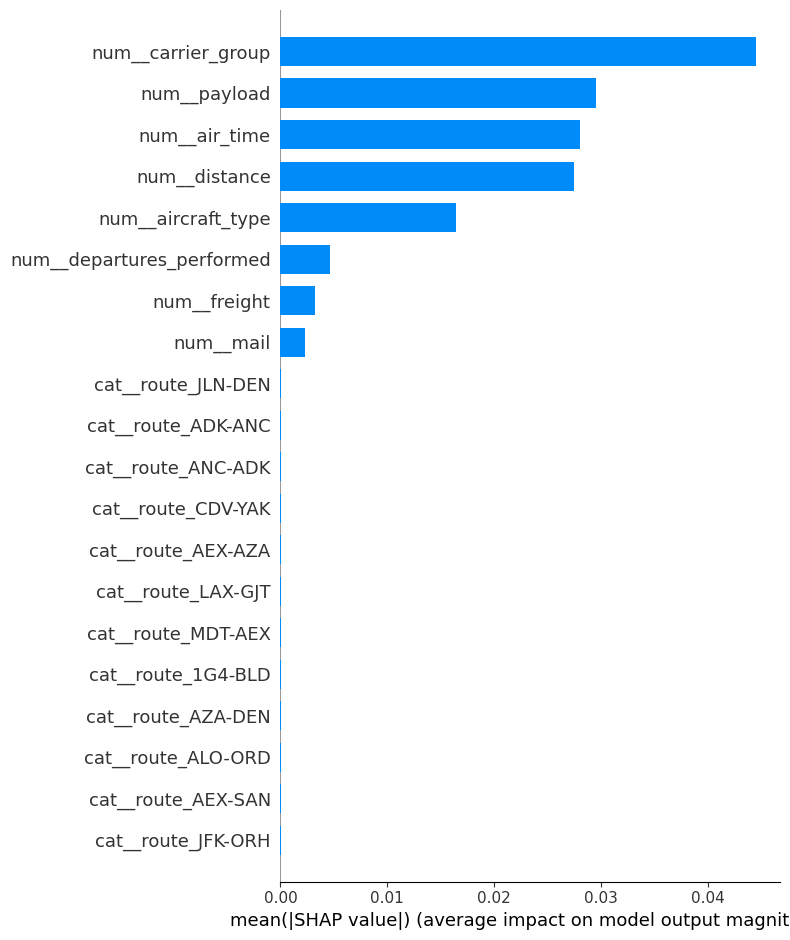

In [27]:
# Define best pipeline
best_pipeline_route = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_model)
])
best_pipeline_route.fit(X_train_route, y_train_route)

# Extract the trained Random Forest model and transformed test data
rf_model_route = best_pipeline_route.named_steps["model"]
X_test_transformed_route = best_pipeline_route.named_steps["preprocessing"].transform(X_test_route)

# Convert sparse matrix to dense array for SHAP
if hasattr(X_test_transformed_route, 'toarray'):
    X_test_transformed_route = X_test_transformed_route.toarray()

# Use a sample for faster SHAP analysis
sample_size = min(1000, X_test_transformed_route.shape[0])  # Use up to 1000 samples
print(f"Using {sample_size} samples for SHAP analysis (out of {X_test_transformed_route.shape[0]} total)")

# Take a random sample
np.random.seed(42)
sample_indices_route = np.random.choice(X_test_transformed_route.shape[0], sample_size, replace=False)
X_sample_route = X_test_transformed_route[sample_indices_route]

# Get feature names
feature_names_route = best_pipeline_route.named_steps["preprocessing"].get_feature_names_out()

# SHAP Explainer
explainer_route = shap.TreeExplainer(rf_model_route)

# SHAP Values on sample
shap_values_route = explainer_route.shap_values(X_sample_route)

# Summary Plot 
shap.summary_plot(
    shap_values_route,
    X_sample_route,
    feature_names=feature_names_route,
    plot_type="bar",
    show=True
)

# NACH OBEN!

Using 1000 samples for SHAP analysis (out of 72038 total)


/var/folders/5z/3zxfyhrd7tjfjt7vh3ns8h480000gn/T/ipykernel_67631/851171717.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


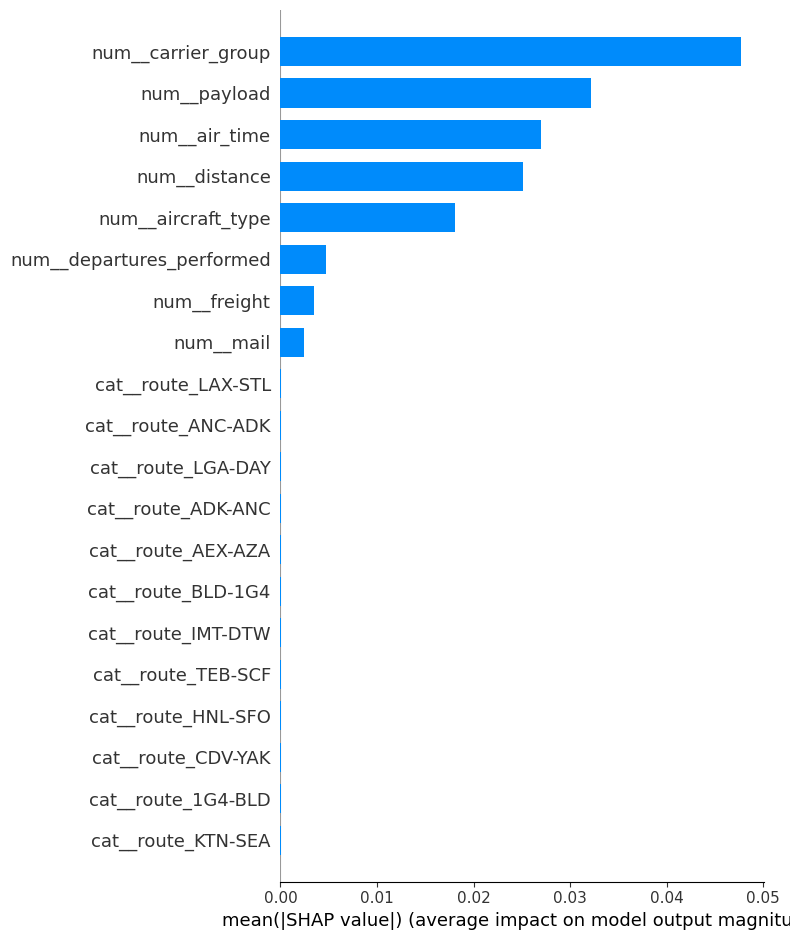

In [28]:
# Define best pipeline for regular split
best_pipeline_regular = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_model)
])
best_pipeline_regular.fit(X_train, y_train)

# Extract the trained Random Forest model and transformed test data
rf_model_regular = best_pipeline_regular.named_steps["model"]
X_test_transformed_regular = best_pipeline_regular.named_steps["preprocessing"].transform(X_test)

# Convert sparse matrix to dense array for SHAP
if hasattr(X_test_transformed_regular, 'toarray'):
    X_test_transformed_regular = X_test_transformed_regular.toarray()

# Use a sample for faster SHAP analysis
sample_size = min(1000, X_test_transformed_regular.shape[0])  # Use up to 1000 samples
print(f"Using {sample_size} samples for SHAP analysis (out of {X_test_transformed_regular.shape[0]} total)")

# Take a random sample
np.random.seed(42)
sample_indices_regular = np.random.choice(X_test_transformed_regular.shape[0], sample_size, replace=False)
X_sample_regular = X_test_transformed_regular[sample_indices_regular]

# Get feature names
feature_names_regular = best_pipeline_regular.named_steps["preprocessing"].get_feature_names_out()

# SHAP Explainer
explainer_regular = shap.TreeExplainer(rf_model_regular)

# SHAP Values on sample
shap_values_regular = explainer_regular.shap_values(X_sample_regular)

# Summary Plot 
shap.summary_plot(
    shap_values_regular,
    X_sample_regular,
    feature_names=feature_names_regular,
    plot_type="bar",
    show=True
)

## Conclusion & Recommendations

Based on the hyperparameter tuning experiments:

1. **Original Random Forest** (n_estimators=100, max_depth=12) achieved **R² = 0.493**
2. **Aggressive RandomizedSearch** led to overfitting with **R² = 0.346** (significant degradation)
3. **Conservative GridSearch** provides a more balanced approach

### Key Findings:
- Hyperparameter tuning doesn't always improve performance
- The original manually chosen parameters were already well-suited for this dataset
- Aggressive parameter ranges (e.g., max_depth=50) can cause severe overfitting
- Conservative tuning with reasonable bounds is safer and more effective

### Final Recommendation:
**Use the best performing model from the comparison above** for production deployment. The original Random Forest with simple, well-chosen parameters often outperforms complex automated tuning attempts.